# **07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación**

## **Estrategia 2: Red pre-entrenada**

### **1. Carga y acondicionamiento del conjunto de datos**
Dataset: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

#### *1.1. Descarga del dataset desde la plataforma kaggle*

In [1]:
#Cargamos el fichero de autenticación de kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
#Descargamos el dataset
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

100% 532M/534M [00:18<00:00, 34.5MB/s]
100% 534M/534M [00:18<00:00, 30.6MB/s]


In [3]:
#Descomprimimos el dataset
!unzip vegetable-image-dataset.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetabl

#### *1.2 Carga del dataset y acondicionamiento de datos*
1. Utilizamos el generador para mayor eficiencia en la carga de datos
2. Utilizamos el parametro class_mode='categorical' para realizar One-hot encoding
3. Con el parámetro rescale=1./255 normalizamos para disminuir el coste computacional


In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir los directorios de los conjuntos de datos
train_dir = 'Vegetable Images/train'
test_dir = 'Vegetable Images/test'
val_dir = 'Vegetable Images/validation'

# Definir el tamaño de imagen que se utilizará para el modelo
img_size = (128, 128)
#img_size = (224, 224)


# Definir el generador de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=15,
    channel_shift_range=0.1,
    width_shift_range=0.1, # Desplazamiento horizontal aleatorio
    height_shift_range=0.1, # Desplazamiento vertical aleatorio
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

# Definir el generador de datos para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

# Definir el generador de datos para el conjunto de validación
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=64,
        class_mode='categorical')

# Obtener los datos y las etiquetas de los generadores de datos
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()
x_val, y_val = val_generator.next()


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


### **2. Inspección del conjunto de datos**

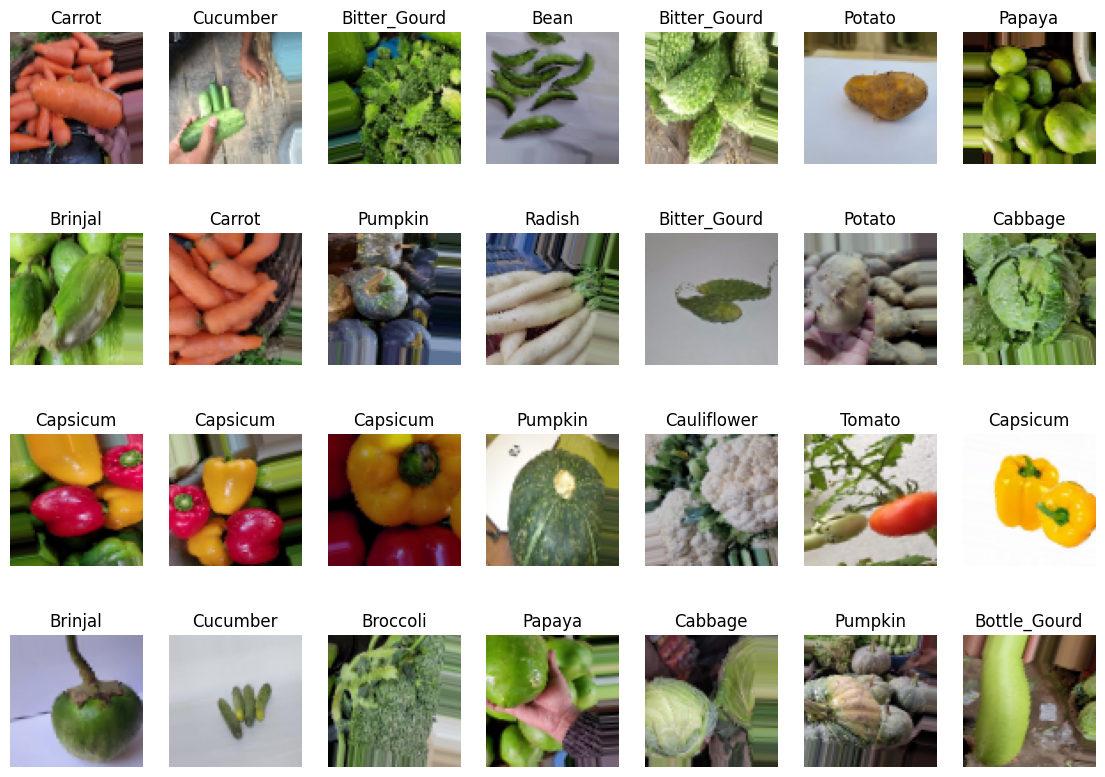

In [ ]:
import matplotlib.pyplot as plt

# Obtener la lista de nombres de las clases
class_names = list(train_generator.class_indices.keys())

fig = plt.figure(figsize=(14,10))
for n in range(1, 29):
    fig.add_subplot(4, 7, n)
    img = x_train[n]
    plt.imshow(img)
    plt.axis('off')
    # Agregar el título de la clase correspondiente
    label_index = y_train[n].argmax()
    plt.title(class_names[label_index])
plt.show()


### **3. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución**

#### **3.1. Arquitectura 1**

In [35]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping


# Definir el factor de regularización de peso
reg_factor = 0.0001
# Definir la tasa de dropout
dropout_rate = 0.0
# Definir la tasa de aprendizaje
learning_rate = 0.01

# Crear el modelo
model = Sequential()

# Añadir capas convolucionales y de pooling
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3), kernel_regularizer=l2(reg_factor)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(reg_factor)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(reg_factor)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(dropout_rate))

#TOP MODEL
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(15,activation='softmax'))

# Definir el optimizador con la tasa de aprendizaje
optimizer = optimizers.SGD(learning_rate)

# Compilar el modelo
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

# Definir el callback para detener el entrenamiento si no hay mejoras en la precisión
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 14, 14, 128)     

In [36]:
# Entrenar el modelo
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    steps_per_epoch=int(train_generator.samples/64), 
    epochs=20, 
    callbacks=[early_stop], 
    initial_epoch=7)

# Evaluar el modelo con los datos de prueba
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Epoch 8/20
234/234 [==============================] - 72s 303ms/step - loss: 2.5166 - accuracy: 0.1789 - val_loss: 2.0807 - val_accuracy: 0.3030
Epoch 9/20
234/234 [==============================] - 71s 302ms/step - loss: 1.8075 - accuracy: 0.4063 - val_loss: 1.4472 - val_accuracy: 0.5220
Epoch 10/20
234/234 [==============================] - 71s 303ms/step - loss: 1.4877 - accuracy: 0.5125 - val_loss: 1.3368 - val_accuracy: 0.5670
Epoch 11/20
234/234 [==============================] - 70s 299ms/step - loss: 1.2783 - accuracy: 0.5853 - val_loss: 1.2170 - val_accuracy: 0.6137
Epoch 12/20
234/234 [==============================] - 71s 302ms/step - loss: 1.1006 - accuracy: 0.6493 - val_loss: 0.8672 - val_accuracy: 0.7463
Epoch 13/20
234/234 [==============================] - 70s 301ms/step - loss: 0.9351 - accuracy: 0.7013 - val_loss: 0.7521 - val_accuracy: 0.7633
Epoch 14/20
234/234 [==============================] - 70s 301ms/step - loss: 0.8164 - accuracy: 0.7393 - val_loss: 0.5668 - v

### **4. Monitorización del proceso de entrenamiento para la toma de decisiones**

In [37]:
import matplotlib.pyplot as plt
import numpy as np
def pintarGrafica(epocas, modelo):
  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, epocas), modelo.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epocas), modelo.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epocas), modelo.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epocas), modelo .history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

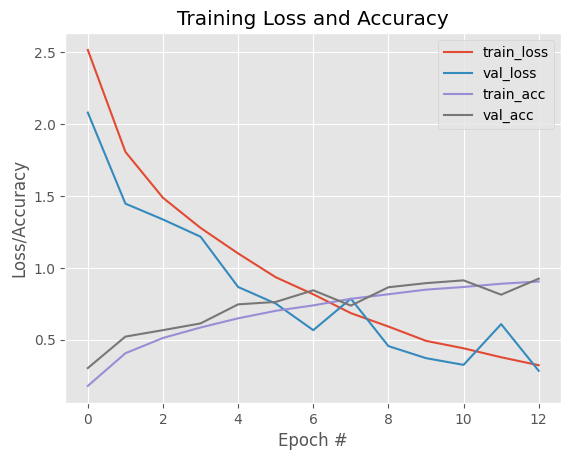

In [38]:
pintarGrafica(13, history)

### **5. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental**

In [39]:
from sklearn.metrics import classification_report

# Obtener las etiquetas verdaderas del conjunto de test
y_true = test_generator.classes

# Obtener las etiquetas predichas del conjunto de test
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Generar el informe de clasificación
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


47/47 [==============================] - 4s 89ms/step
              precision    recall  f1-score   support

        Bean       0.09      0.08      0.08       200
Bitter_Gourd       0.08      0.08      0.08       200
Bottle_Gourd       0.10      0.10      0.10       200
     Brinjal       0.06      0.04      0.05       200
    Broccoli       0.05      0.07      0.06       200
     Cabbage       0.08      0.07      0.08       200
    Capsicum       0.06      0.06      0.06       200
      Carrot       0.05      0.06      0.05       200
 Cauliflower       0.06      0.06      0.06       200
    Cucumber       0.07      0.07      0.07       200
      Papaya       0.08      0.08      0.08       200
      Potato       0.07      0.07      0.07       200
     Pumpkin       0.08      0.09      0.08       200
      Radish       0.07      0.07      0.07       200
      Tomato       0.06      0.06      0.06       200

    accuracy                           0.07      3000
   macro avg       0.07   

In [40]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

47/47 [==============================] - 5s 97ms/step - loss: 0.2510 - accuracy: 0.9287
Test loss: 0.2509501874446869
Test accuracy: 0.9286666512489319


### **6. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental**

In [41]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.3 MB/s eta 0:00:00


In [42]:
import tensorflow as tf
import IPython
import keras_tuner as kt

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=2,
    verbose=0,
    mode='auto',
    restore_best_weights=True,
    start_from_epoch=10
)


def model_builder(hp):
    #########################################
    ###### Definimos la arquitectura ########
    #########################################
    # Definir el factor de regularización de peso
    hp_weight = hp.Choice('weight_regularization', values = [1e-2, 1e-3, 1e-4]) 
    # Definir la tasa de dropout
    hp_dropout = hp.Choice('dropout', values = [0.0, 0.1, 0.2])
    # Definir la tasa de aprendizaje
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    # Definir el optimizador
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    
    # Crear el modelo
    model = Sequential()

    # Añadir capas convolucionales y de pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3), kernel_regularizer=l2(hp_weight)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(hp_weight)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(hp_weight)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp_dropout))

    #TOP MODEL
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dropout(hp_dropout))
    model.add(layers.Dense(15,activation='softmax'))

    # Compilar el modelo
    if optimizer == 'adam':
        model.compile(optimizer=optimizers.Adam(hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=optimizers.SGD(hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) 
        
    return model


In [43]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 20,
                     seed = 42)  

In [ ]:
tuner.search(train_generator, validation_data = val_generator, steps_per_epoch = int(train_generator.samples / 64), epochs=20,
             callbacks = [ClearTrainingOutput(), EarlyStoppingCallback])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal dropout is {best_hps.get('dropout')}. The 
optimal weight regularization is {best_hps.get('weight_regularization')}
""")

Trial 1 Complete [00h 03m 39s]
val_accuracy: 0.890999972820282

Best val_accuracy So Far: 0.890999972820282
Total elapsed time: 00h 03m 39s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
0.0001            |0.001             |weight_regularization
0.1               |0                 |dropout
0.001             |0.001             |learning_rate
adam              |adam              |optimizer
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
234/234 [==============================] - 73s 304ms/step - loss: 1.4047 - accuracy: 0.5368 - val_loss: 0.7414 - val_accuracy: 0.7660
Epoch 2/3
234/234 [==============================] - 71s 305ms/step - loss: 0.6544 - accuracy: 0.7862 - val_loss: 0.4807 - val_accuracy: 0.8453
Epoch 3/3
139/234 [================>.............] - ETA: 27s - loss: 0.44